In [1]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate();
#import Pkg; Pkg.activate(joinpath(@__DIR__,"..")); Pkg.instantiate();

  Activating environment at `~/Desktop/repos/courses/seattle/CSE579-main/LQ_Game_Solver/CS_project/Project.toml`


In [2]:
using LinearAlgebra;
using Plots;
using SparseArrays;
using ForwardDiff;
using Random;
#using ControlSystems

### 2D Point Mass Continous dynamics

The 2D point masses with mass $m=1\; \text{kg}$ are subject to input forces $F_{ext}$ and damping coefficient $c = 0.1\;[N \cdot \frac{s}{m}]$.


\begin{split}
\dot p &= v\\
\dot v &= -\frac{b}{m}v + \frac{1}{m}F_{ext}
\end{split}

In [3]:
c = 0.1     # Damping coefficient [N-s/m]
m = 1.0     # Mass [kg]

# State x: [x, y, ̇x, ̇y]
# Input u: [Fₓ, F\_y]

function point_mass(x, u)
    ẋ = x[3]
    ẍ = -(c/m)*ẋ + u[1]/(m)   
    ẏ = x[4]
    ÿ = -(c/m)*ẏ + u[2]/(m)  
    return [ẋ; ẏ; ẍ; ÿ]
end

point_mass (generic function with 1 method)

### Linearizing and discretizing the dynamics

In [4]:
function lin_dyn_discrete(dynamics, x, u, dt)
    A = ForwardDiff.jacobian(dx -> dynamics(dx, u), x)
    B = ForwardDiff.jacobian(du -> dynamics(x, du), u)
    A = dt .* A + I
    B = dt .* B
    return A, B
end

lin_dyn_discrete (generic function with 1 method)

In [78]:
# Constraint 
obstacle = [9.0, 10.0, 0.0, 0.0]
dmax = 5.0

outside_weight = 0.25

ρ = 5000.0

5000.0

In [108]:
Q = 1.0*I(4) #state cost for point mass 1
R = 1.0*I(2)
Qn = 5.0*I(4)

function cost(x, u, xgoal, ugoal, B)
    dx = x - xgoal
    du = u - ugoal 
    rel_dist = (x[1:2] - obstacle[1:2])'*I*(x[1:2] - obstacle[1:2])

    return 0.5*dx'*Q*dx + 0.5*du'*R*du + ρ*(min(sqrt(rel_dist) - dmax, 0))^2    
end

cost (generic function with 1 method)

(size(dx), size(dy)) = ((601,), (601,))


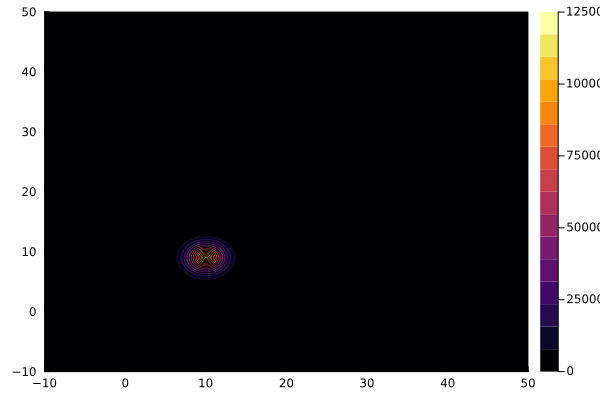

In [81]:
xtest = [0.0, 0.0, 0.0, 0.0]
utest = [0.0,0.0]
xgoaltest = [20.0,20.0,0.0,0.0]
ugoal = [0.0,0.0]

xstart = -10.0
xend = 50.0

dx = range(xstart, xend, step = 0.1)
dy = range(xstart, xend, step = 0.1)

@show size(dx), size(dy)

costvalues = zeros(length(dx),length(dy))

for i = 1:length(dx)
    xtest = [0.0, 0.0, 0.0, 0.0]
    xval = dx[i]
    for j=1:length(dy)
        yval = dy[j]
        xtest[1] = xval
        xtest[2] = yval
        costvalues[i,j] = cost(xtest,utest,xgoaltest,ugoal, false)
    end
end

plot(dx, dy,costvalues, fill=true)

In [82]:
# Good
# function costnoconstraint(x, u, xgoal, ugoal, B)

#     goal = x - xgoal# check x or x̂
#     rel_dist = (x[1:2] - obstacle[1:2])'*I*(x[1:2] - obstacle[1:2])
#     if B 
#         return 0.5*goal'*Qn*goal #+ ρ/(exp(rel_dist))
#     else            
#         dx = x - xgoal
#         du = u - ugoal
#         if rel_dist < dmax 
#             return 0.5*dx'*Q*dx + 0.5*du'*R*du #+ rel_dist
#         else 
#             outside_penalty = outside_weight*(rel_dist + dmax - 2*sqrt(rel_dist*rel_dist))
#             return 0.5*dx'*Q*dx + 0.5*du'*R*du #+ outside_penalty + dmax
#         end
        
#     end
# end

# xtest = [0.0, 0.0, 0.0, 0.0]
# utest = [0.0,0.0]
# xgoaltest = [20.0,20.0,0.0,0.0]
# ugoal = [0.0,0.0]

# xstart = -10.0
# xend = 50.0

# dx = range(xstart, xend, step = 0.1)
# dy = range(xstart, xend, step = 0.1)

# @show size(dx), size(dy)

# costvalues = zeros(length(dx),length(dy))

# for i = 1:length(dx)
#     xtest = [0.0, 0.0, 0.0, 0.0]
#     xval = dx[i]
#     for j=1:length(dy)
#         yval = dy[j]
#         xtest[1] = xval
#         xtest[2] = yval
#         costvalues[i,j] = costnoconstraint(xtest,utest,xgoaltest,ugoal, false)
#     end
# end

# plot(dx, dy,costvalues)

In [83]:
# Good

# function costconstraint(x, u, xgoal, ugoal, B)

#     goal = x - xgoal# check x or x̂
#     rel_dist = (x[1:2] - obstacle[1:2])'*I*(x[1:2] - obstacle[1:2])
#     if B 
#         return 0.5*goal'*Qn*goal #+ ρ/(exp(rel_dist))
#     else            
#         dx = x - xgoal
#         du = u - ugoal
#         if rel_dist < dmax 
#             return rel_dist
#         else 
#             outside_penalty = outside_weight*(rel_dist + dmax - 2*sqrt(rel_dist*rel_dist))
#             return outside_penalty + dmax
#         end
        
#     end
# end

# xtest = [0.0, 0.0, 0.0, 0.0]
# utest = [0.0,0.0]
# xgoaltest = [20.0,20.0,0.0,0.0]
# ugoal = [0.0,0.0]

# xstart = -10.0
# xend = 50.0

# dx = range(xstart, xend, step = 0.1)
# dy = range(xstart, xend, step = 0.1)

# @show size(dx), size(dy)

# costvalues = zeros(length(dx),length(dy))

# for i = 1:length(dx)
#     xtest = [0.0, 0.0, 0.0, 0.0]
#     xval = dx[i]
#     for j=1:length(dy)
#         yval = dy[j]
#         xtest[1] = xval
#         xtest[2] = yval
#         costvalues[i,j] = costconstraint(xtest,utest,xgoaltest,ugoal, false)
#     end
# end

# plot(dx, dy,costvalues)

### Cost Function (add distance constrain to arbitary static object)

In [84]:
# Q = 1.0*I(4) #state cost for point mass 1
# R = 1.0*I(2)
# Qn = 0.1*I(4)

# # function cost(x, u)
# #     c = 0.5*x'*Q*x + 0.5*u'*R*u + rho*min(sqrt((x[1:2] - obstacle[1:2])'*(x[1:2] - obstacle[1:2])), 0)
# #     return c
# # end

# function cost(x, u, xgoal, ugoal, B)

#     goal = x - xgoal# check x or x̂

#     if B 
#         return 0.5*goal'*Qn*goal
#     else            
#         dx = x - xgoal
#         du = u - ugoal
#         return 0.5*dx'*Q*dx + 0.5*du'*R*du
#     end
# end

# rel_dist = (x[1:2] - obstacle[1:2])'*(x[1:2] - obstacle[1:2])
# if rel_dist < dmax 
#     c = 0.5*x'*Q*x + 0.5*u'*R*u - rel_dist
# else
#     outside_penalty = outside_weight*(rel_dist + dmax - 2*sqrt(rel_dist*dmax))
#     c = 0.5*x'*Q*x + 0.5*u'*R*u - outside_penalty - dmax
# end

### Quadritizing cost function

In [85]:
function quadratic_cost(cost_fun, x, u, xgoal, ugoal, B)
    """
    2nd order Taylor expansion of cost at t
    I neglected the mixed paritals in the hessian
    """
    Q = ForwardDiff.hessian(dx -> cost_fun(dx, u, xgoal, ugoal, B), x)
    l = ForwardDiff.gradient(dx -> cost_fun(dx, u, xgoal, ugoal, B), x)
    R = ForwardDiff.hessian(du -> cost_fun(x, du, xgoal, ugoal, B), u)
    r = ForwardDiff.gradient(du -> cost_fun(x, du, xgoal, ugoal, B), u)

    if B
        dx = x - xgoal
        du = u
    else
        dx = x - xgoal
        du = u - ugoal
    end
    cost = 0.5 * dx' * (Q*dx + 2*l) + 0.5 * du' * (R*du + 2*r)
    return cost, Q, l, R, r
end

quadratic_cost (generic function with 1 method)

In [86]:
# function costconstraint(x, u, xgoal, ugoal, B)

#     goal = x - xgoal# check x or x̂
#     rel_dist = (x[1:2] - obstacle[1:2])'*I*(x[1:2] - obstacle[1:2])
#     if B 
#         return 0.5*goal'*Qn*goal #+ ρ/(exp(rel_dist))
#     else            
#         dx = x - xgoal
#         du = u - ugoal
#         if rel_dist < dmax 
#             return rel_dist
#         else 
#             outside_penalty = outside_weight*(rel_dist + dmax - 2*sqrt(rel_dist*rel_dist))
#             return outside_penalty + dmax
#         end
        
#     end
# end

xtest = [0.0, 0.0, 0.0, 0.0]
utest = [0.0,0.0]
xgoaltest = [20.0,20.0,0.0,0.0]
ugoal = [0.0,0.0]

xstart = -10.0
xend = 50.0

dx = range(xstart, xend, step = 0.05)
dy = range(xstart, xend, step = 0.05)

costvalues = zeros(length(dx),length(dy))

for i = 1:length(dx)
    xtest = [0.0, 0.0, 0.0, 0.0]
    xval = dx[i]
    for j=1:length(dy)
        yval = dy[j]
        xtest[1] = xval
        xtest[2] = yval
        costvalues[i,j],_,_,_ = quadratic_cost(cost, xtest, utest, xgoaltest, ugoal, false)
    end
end

plot(dx, dy,costvalues, fill=true)

In [87]:
function compute_quad_cost(cost_fun, l, r, x, u, xgoal, ugoal, B)
    l = ForwardDiff.gradient(dx -> cost_fun(dx, u, xgoal, ugoal, B), x)
    r = ForwardDiff.gradient(du -> cost_fun(x, du, xgoal, ugoal, B), u)
    dx = x - xgoal
    du = u - ugoal
    cost = dx' *l + du' * r
    return cost
end

compute_quad_cost (generic function with 1 method)

In [88]:
# xₜ = [10; 10.0; 0.0; 0.0]
# xgoal = [20.0; 20.0; 0.0; 0.0]
# ugoal = [0, 0]
# uₜ = [2.0; 2.0]
# rel_dist = (xₜ[1:2] - obstacle[1:2])'*I*(xₜ[1:2] - obstacle[1:2])
# println("rel_dist ", rel_dist)
# costs, Qₜ, lₜ, Rₜ, rₜ = quadratic_cost(cost, xₜ, uₜ, xgoal, ugoal, false)
# println("actual cost ", cost(xₜ, uₜ, xgoal, ugoal, false))
# @show costs
# @show Qₜ
# @show lₜ
# @show Rₜ
# @show rₜ

#### Point Mass Discrete

$$ \frac{d}{dt}x = Ax + \sum Bu$$

Single 2D point mass:
$$\frac{d}{dt}\begin{bmatrix} x \\ y \\ \dot{x} \\ \dot{y}\end{bmatrix} =  
 \begin{bmatrix} 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & 0 & -c/m & 0 \\ 0 & 0 & 0 & -c/m \end{bmatrix}
 \begin{bmatrix} x \\ y \\ \dot{x} \\ \dot{y}\end{bmatrix} + 
 \begin{bmatrix} 0 & 0 \\ 0 & 0 \\ 1/m & 0 \\ 0 & 1/m \end{bmatrix}
 \begin{bmatrix} u_x \\ u_y\end{bmatrix} $$

two 2D point masses:
$$\frac{d}{dt}\begin{bmatrix} x_1 \\ y_1 \\ \dot{x}_1 \\ \dot{y}_1 \\ x_2 \\ y_2 \\ \dot{x}_2 \\ \dot{y}_2\end{bmatrix} =  
 \begin{bmatrix} 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0\\ 
                0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 \\ 
                0 & 0 & -c/m_1 & 0 & 0 & 0 & 0 & 0\\ 
                0 & 0 & 0 & -c/m_1 & 0 & 0 & 0 & 0\\
                0 & 0 & 0 & 0 & 0 & 0 & 1 & 0\\ 
                0 & 0 & 0 & 0 & 0 & 0 & 0 & 1\\ 
                0 & 0 & 0 & 0 & 0 & 0 & -c/m_2 & 0\\ 
                0 & 0 & 0 & 0 & 0 & 0 & 0 & -c/m_2\\ \end{bmatrix}
 \begin{bmatrix} x_1 \\ y_1 \\ \dot{x}_1 \\ \dot{y}_1 \\ x_2 \\ y_2 \\ \dot{x}_2 \\ \dot{y}_2\end{bmatrix} + 
 \begin{bmatrix} 0 & 0 \\ 0 & 0 \\ 1/m_1 & 0 \\ 0 & 1/m_1 \\ 0 & 0 \\ 0 & 0 \\ 0 & 0 \\ 0 & 0\end{bmatrix}
 \begin{bmatrix} u_x^1 \\ u_y^1 \end{bmatrix} +
 \begin{bmatrix} 0 & 0 \\ 0 & 0 \\ 0 & 0 \\ 0 & 0 \\ 0 & 0 \\ 0 & 0 \\ 1/m_2 & 0 \\ 0 & 1/m_2\end{bmatrix}
 \begin{bmatrix} u_x^2 \\ u_y^2 \end{bmatrix}  $$


### Single Iteration of Affine QR

In [89]:
n = 4 #8 states
m = 2 #2 controls
function affinelq!(Aₜ, Bₜ, Qₜ, lₜ, Rₜ , rₜ)

    V = copy(Qₜ[:,:,end]) #at last time step
    ζ = copy(lₜ[:,end]) #at last time step
    #P = zeros(k_steps, n*m)
    P = zeros(Float32, (m, n, k_steps))
    #α = zeros(k_steps, m)
    α = zeros(Float32, (m, k_steps))

    #α₂ = zeros(T[1], m)

    for t in (k_steps-1):-1:1
        # solving for Ps, check equation 19 in document
        # Player 1
        # Equation (10) only for 1 player for Pⱼ = 0 
        # println(Rₜ[:,:,t])
        # println(Bₜ[:,:,t])
        # println(V)
        Pₜ = (Rₜ[:,:,t] + (Bₜ[:,:,t]' * V * Bₜ[:,:,t]))\(Bₜ[:,:,t]' * V * Aₜ[:,:,t])
        # Equation (11) only for 1 player for for αⱼ = 0
        αₜ = (Rₜ[:,:,t] + (Bₜ[:,:,t]' * V * Bₜ[:,:,t]))\(Bₜ[:,:,t]' * ζ)
        # Assign Values
        P[:,:,t] = Pₜ
        α[:,t] = αₜ
        #Update value function(s)
        # Equation (14)
        Fₜ = Aₜ[:,:,t] - (Bₜ[:,:,t]*Pₜ)
        # Equation (15)
        βₜ = - Bₜ[:,:,t] * αₜ
        # Equation (17)
        ζ = lₜ[:,t] + (Pₜ' * Rₜ[:,:,t] * αₜ - Pₜ' * rₜ[:,t]) + Fₜ'*(ζ + V * βₜ)
        # Equation (16) where V = Z
        V = Qₜ[:,:,t] + (Pₜ' * Rₜ[:,:,t] * Pₜ) + (Fₜ' * V * Fₜ)
    end
    return P, α
end

affinelq! (generic function with 1 method)

### Rollout a (nonlinear) trajectory

In [90]:
x = [0,0]
lo = [-1,1]
hi = [2,2]
x .= clamp.(x, lo, hi)

2-element Vector{Int64}:
 0
 1

In [91]:
function Rollout_RK4(fun, x₀, x̂, û, H, dt, P, α, α_scale)
    """
    Rollout dynamics with initial state x₀ 
    and control law u = -Px - α
    P is an n x b gain matrix
    α is m x 1
    """
    umax = [10,10]
    umin = [-10,-10]
    m = 2 #2 controls
    k_steps = trunc(Int, H/dt) 
    xₜ = zeros(k_steps, length(x₀)) # 1500 x n
    uₜ = zeros(k_steps, m) 
    xₜ[1,:] .= x₀
    for t=1:(k_steps-1)
        # WHAT IS x̂ in xₜ[t,:] - x̂
        #uₜ[t,:] .= clamp.([0,0] - P[:,:,t]*(xₜ[t,:] - [20,20,0,0]) - α[:,t], umin, umax)
        uₜ[t,:] .= clamp.(û[t,:] - P[:,:,t]*(xₜ[t,:] - x̂[t,:]) - α_scale*α[:,t], umin, umax)
        k1 = fun(xₜ[t,:], uₜ[t,:])
        k2 = fun(xₜ[t,:] + 0.5*dt*k1, uₜ[t,:])
        k3 = fun(xₜ[t,:] + 0.5*dt*k2, uₜ[t,:])
        k4 = fun(xₜ[t,:] + dt*k3, uₜ[t,:])
        xₜ[t+1,:] = xₜ[t,:] + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)
    end
    
    return xₜ, uₜ
end

Rollout_RK4 (generic function with 1 method)

In [92]:
function isConverged(current, last, tolerance = 1e-4)
    if norm(current - last) > tolerance
        return false
    else 
        return true
    end
end

isConverged (generic function with 2 methods)

### Initiating P's and alpha's

In [93]:
# x₀=[0; 0; 0; 0]
dt = 0.1 #step size
H = 15.0  #Horizon
k_steps = Int(H/dt)

P = rand(2,4,k_steps)*0.1
α = rand(2,k_steps)*0.1

2×150 Matrix{Float64}:
 0.0807338  0.071487   0.0796572  …  0.0838664  0.073181    0.0843617
 0.0455146  0.0639612  0.0521866     0.0777746  0.00696014  0.058193

In [94]:
#function ilqr()
# 1. Initialize an initial feasible trajectory

n = 4
m = 2
x₀ = [0.0; 0.0; 0.0; 0.0]
xgoal = [20.0; 20.0; 0.0; 0.0]
x̂ = zeros(k_steps, length(x₀)) # 1500 x need
û = zeros(k_steps, m) 
xₜ, uₜ = Rollout_RK4(point_mass, x₀, x̂, û, H, dt, P, α, 1.0) #xₜ is [k_steps, 4]
Aₜ = zeros(Float32, (n, n, k_steps))
Bₜ = zeros(Float32, (n, m, k_steps))
Qₜ = zeros(Float32, (n, n, k_steps))
lₜ = zeros(Float32, (n, k_steps))
Rₜ = zeros(Float32, (m, m, k_steps))
rₜ = zeros(Float32, (m, k_steps))
costs = zeros(k_steps);

# x̂ = xₜ
# û = uₜ

In [95]:
#println(total_cost)
converged = false
ugoal = [0, 0]
all_cost = []
βreg = 1.0
αₗ = [1.0, 0.6, 0.4, 0.2, 0.1, 0.01]
while !converged
#for i in 1:50
    converged = isConverged(xₜ, x̂, 1e-3)
    #println(converged)
    total_cost = 0
    for t = 1:(k_steps-1)
        # 2. Linearize dynamics about trajectory
        # WHAT IS x̂ in xₜ[t,:] - x̂
        dx = xₜ[t,:] - x̂[t,:]
        du = uₜ[t,:] - û[t,:]
        Aₜ[:,:,t], Bₜ[:,:,t] = lin_dyn_discrete(point_mass, dx, du, dt)
        # 3. Compute second order Taylor series expansion the cost function
        # WHAT IS x̂ in xₜ[t,:] - x̂
        costval, Qₜ[:,:,t], lₜ[:,t], Rₜ[:,:,t], rₜ[:,t] = quadratic_cost(cost, xₜ[t,:], uₜ[t,:], xgoal, ugoal, false)

        # Regularization
        while !isposdef(Qₜ[:,:,t])
            r = zeros(4,4)
            r[2,1] = 1
            Qₜ[:,:,t] = round.(Qₜ[:,:,t]) + βreg*I #+ r
            # @show Qₜ[:,:,t]
        end
        # @show Rₜ[:,:,t] 
        total_cost += costval 
    end
    costval, Qₜ[:,:,end], lₜ[:,end], Rₜ[:,:,end], rₜ[:,end] = quadratic_cost(cost, xₜ[end,:], uₜ[end,:], xgoal, ugoal, true)

    total_cost += costval
    # @show costs[end]
    # 4. Do lqr
    P, α = affinelq!(Aₜ, Bₜ, Qₜ, lₜ, Rₜ , rₜ);

    x̂ = xₜ
    û = uₜ
    xₜ, uₜ = Rollout_RK4(point_mass, x₀, x̂, û, H, dt, P, α, 0.1)
    #println(converged)

    push!(all_cost, total_cost)
    #@show xₜ[1,:] 
    #@show xₜ[end,:]
    @show total_cost
end

total_cost = 187642.9464567057
total_cost = 157324.0130119695
total_cost = 132732.06631229122
total_cost = 112788.87273621102
total_cost = 1.7871882439089626e8
total_cost = 1.8112656736480096e8
total_cost = 1.8347991183534747e8
total_cost = 1.8574373421780547e8
total_cost = 1.8791649586842963e8
total_cost = 1.9003450573042265e8
total_cost = 1.92205277279776e8
total_cost = 1.939010796968817e8
total_cost = 1.9555655449456638e8
total_cost = 1.9715818100112173e8
total_cost = 1.9867664771424422e8
total_cost = 2.002394691617326e8
total_cost = 2.0151366241991618e8
total_cost = 2.0469113767321125e8
total_cost = 2.058435961989267e8
total_cost = 2.0670380274741927e8
total_cost = 2.056571061305376e8
total_cost = 2.1277231240967387e8
total_cost = 2.0964866023297244e8
total_cost = 2.1025779861898586e8
total_cost = 2.1045933615567592e8
total_cost = 2.0909891181581345e8
total_cost = 2.2137894179474914e8
total_cost = 2.177214348293028e8
total_cost = 2.1030156395596683e8
total_cost = 2.1849990708000636

In [96]:
#     for α_scale in αₗ
#         xₜ, uₜ = Rollout_RK4(point_mass, x₀, x̂, û, H, dt, P, α, α_scale)
#         costₙ = 0
#         for t = 1:(k_steps-1)
#             costNow, ~, ~, ~, ~ = quadratic_cost(cost, xₜ[t,:], uₜ[t,:], xgoal, ugoal, false)
#             #costₙ += compute_quad_cost(cost, lₜ[:,t], rₜ[:,t], xₜ[t,:], uₜ[t,:], xgoal, ugoal, false)
#             costₙ += costNow
#         end
#         costNow, ~, ~, ~, ~ = quadratic_cost(cost, xₜ[end,:], uₜ[end,:], xgoal, ugoal, true)
#         costₙ += costNow
#         #costₙ += compute_quad_cost(cost, lₜ[:,end], rₜ[:,end], xₜ[end,:], uₜ[end,:], xgoal, ugoal, true)
#         if costₙ < total_cost
#             break
#         # else 
#         #     converged = true
#         end
#     end

In [97]:
all_cost

811-element Vector{Any}:
 187642.9464567057
 157324.0130119695
 132732.06631229122
 112788.87273621102
      1.7871882439089626e8
      1.8112656736480096e8
      1.8347991183534747e8
      1.8574373421780547e8
      1.8791649586842963e8
      1.9003450573042265e8
      1.92205277279776e8
      1.939010796968817e8
      1.9555655449456638e8
      ⋮
      1.2737981240709359e6
      1.2737999740585526e6
      1.2738018929292748e6
      1.2738038699746754e6
      1.273805928522717e6
      1.2738080507880305e6
      1.27381021701572e6
      1.2738124612683877e6
      1.2738147593225206e6
      1.2738171407991669e6
      1.27381956037366e6
      1.2738220656764025e6

In [98]:
xₜ[end, :] #45757

4-element Vector{Float64}:
 19.95457085025955
 19.974895625903205
  0.024553167495282982
 -0.005432100316389202

In [99]:
function circleShape(h, k, r)
    θ = LinRange(0, 2*π, 500)
    h .+ r*sin.(θ), k.+ r*cos.(θ)
end

circleShape (generic function with 1 method)

┌ Info: Saved animation to /home/ahmed/Desktop/repos/courses/seattle/CSE579-main/LQ_Game_Solver/CS_project/obstacle.gif
└ @ Plots /home/ahmed/.julia/packages/Plots/YbrTT/src/animation.jl:149


Plots.AnimatedGif("/home/ahmed/Desktop/repos/courses/seattle/CSE579-main/LQ_Game_Solver/CS_project/obstacle.gif")
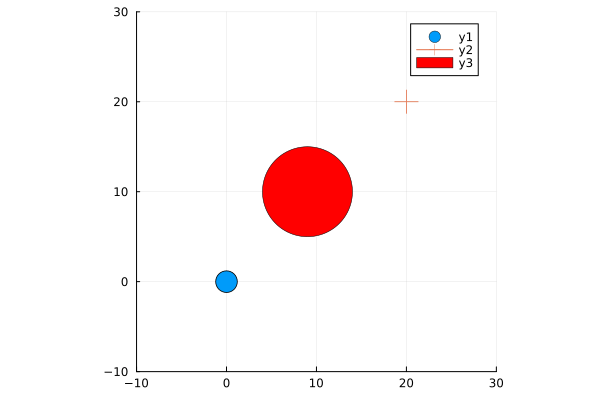

In [100]:
anim = @animate for t in 1:k_steps
    scatter([xₜ[t, 1]], [xₜ[t, 2]], m = (:circle, 12),
    xlims = (-10, 30), 
    ylims = (-10, 30), )
    plot!([xgoal[1]], [xgoal[2]], m = (:cross, 12))
    plot!(circleShape(obstacle[1], obstacle[2], dmax), seriestype = [:shape,], lw = 0.5, c = :red, linecolor=:black, aspect_ratio=1)end every 10;
gif(anim, "static_obstacle.gif")

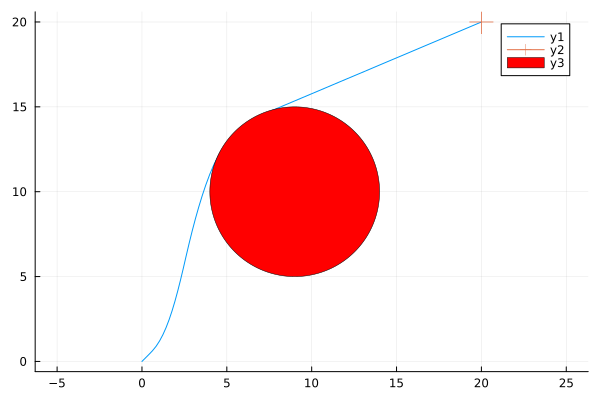

In [101]:
plot([xₜ[:, 1]], [xₜ[:, 2]])
plot!([xgoal[1]], [xgoal[2]], m = (:cross, 12))
plot!(circleShape(obstacle[1], obstacle[2], dmax), seriestype = [:shape,], lw = 0.5, c = :red, linecolor=:black, aspect_ratio=1)

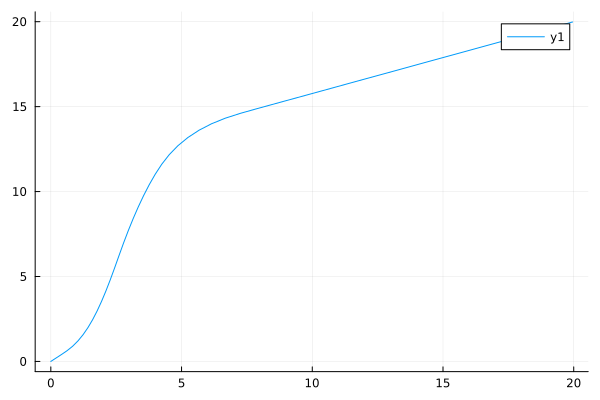

In [102]:
plot([xₜ[:, 1]], [xₜ[:, 2]])

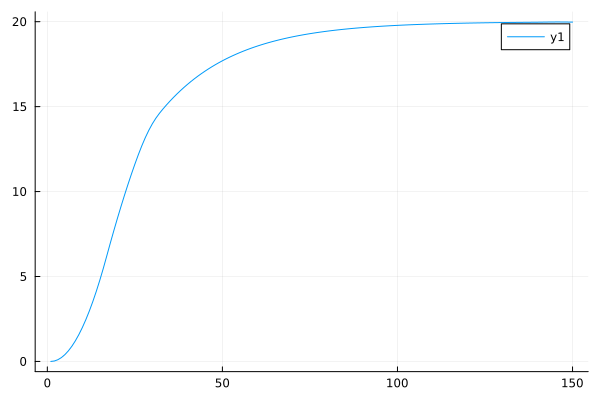

In [103]:
plot([xₜ[:, 2]])

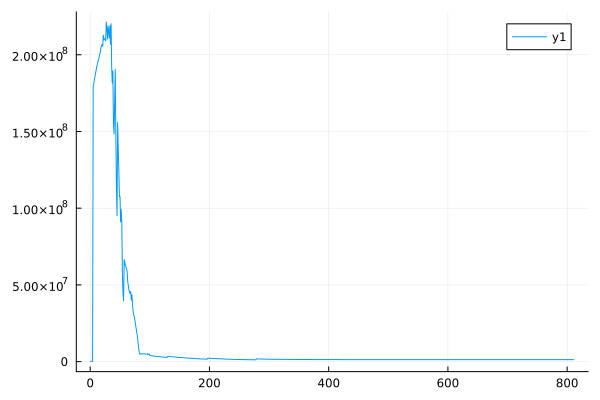

In [104]:
plot(all_cost)

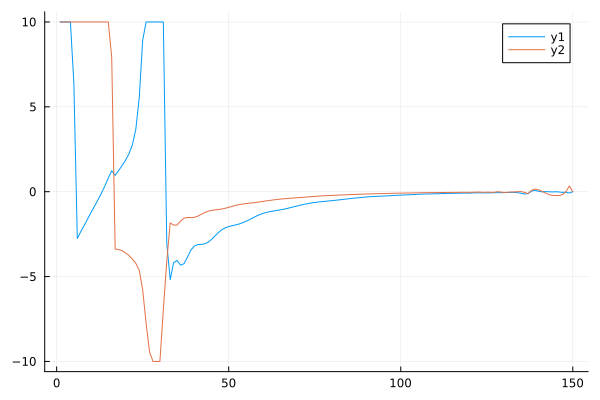

In [105]:
plot(uₜ)

In [107]:
xₜ[end,:]

4-element Vector{Float64}:
 19.95457085025955
 19.974895625903205
  0.024553167495282982
 -0.005432100316389202